In [56]:
#import/install all packages at the top

import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from spacy.lang.en.stop_words import STOP_WORDS
import string
import get_all_tokens

# Sections:

# (1) Import dataset and split
# (2) Functions
# (3) Irony Feature Extraction
- (3.1) Average Word Count
- (3.2) Average Sentence Count
- (3.3) Punctuation Richness
- (3.4) Sarcasm Symbol
- (3.5) Upper-case Words
- (3.6) Individual Punctuation Count
- (3.7) Word Type Count
- (3.8) Named Entity Count

# (4) No-irony Feature Extraction
- (4.1) Average Word Count
- (4.2) Average Sentence Count
- (4.3) Punctuation Richness
- (4.4) Sarcasm Symbol
- (4.5) Upper-case Words
- (4.6) Individual Punctuation Count
- (4.7) Word Type Count
- (4.8) Named Entity Count

# (5) Get Final Summary Stats (ironic vs non-ironic)
------------ DataFrame Table, Save to CSV and Visualisation
- (5.1) Generl Summary
- (5.2) Individual Punctuation Count Summary
- (5.3) Word Type Count Summary
- (5.4) Named Entity Count Summary

In [4]:
#import and read file in df with pandas (for better visualisation)

filename= "/Users/laure/OneDrive/Dokumente/VU/Python for Text Analysis/Final Assignment/irony-labeled.csv"

gold_label = pd.read_csv(filename)

In [5]:
#rename the columns
gold_label.columns = ["Comment_Text", "Label"]

In [8]:
#checking for any missing values
missing_data = gold_label.isnull().sum()
missing_data

Comment_Text    0
Label           0
dtype: int64

In [11]:
#counts number of each class 
gold_label["Label"].value_counts()

#1 ironic
#-1 non-ironic

-1    1412
 1     537
Name: Label, dtype: int64

In [10]:
print("This dataset of Ironic and Non-ironic Reddit Comments entails", len(gold_label), "items")

This dataset of Ironic and Non-ironic Reddit Comments entails 1949 items


# Split into Train (70), Validation (10) and Test (20) sets

-using scikit learn 'train_test_split' function twices gives the validation set

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
#split df to get two dfs by column
y = gold_label["Comment_Text"]
x = gold_label["Label"]

In [16]:
#test and train sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

#split the training set to get validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=43)

In [18]:
#pandas concat joins series together (i.e. dataframes)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
val = pd.concat([X_val, y_val], axis=1)

In [19]:
# pandas '.shape' to see dataframe in form of tuples (no. of rows / cols)

print("Training Data Shape:", train.shape)
print("Testing Data Shape:", test.shape)
print("Validation Data Shape:", val.shape)

Training Data Shape: (1364, 2)
Testing Data Shape: (390, 2)
Validation Data Shape: (195, 2)


# Summary of distribution of comments by labels 
# (Non-ironic = -1, Ironic = 1)

- use matplotlib to create THREE bar charts for visualisation for each of the sets:
        (1) Train
        (2) Validation
        (3) Test

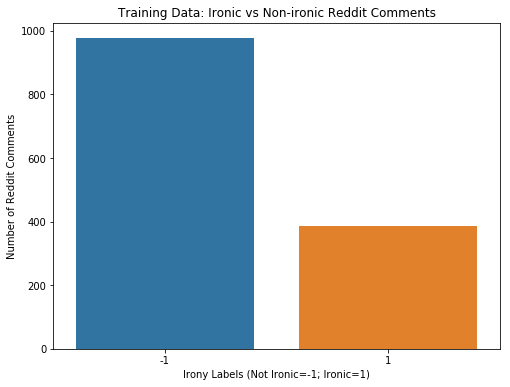

In [22]:
#TRAIN

fig = plt.figure(figsize=(8,6))
sns.barplot(x = train["Label"].unique(), 
            y=train["Label"].value_counts())

plt.title("Training Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

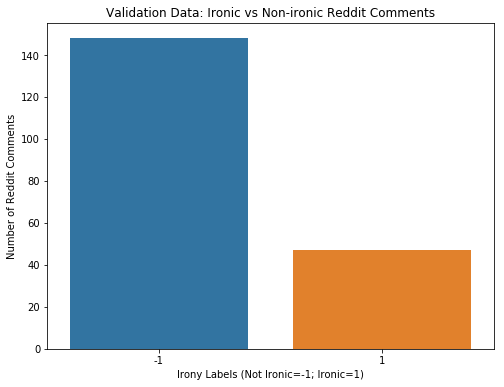

In [23]:
#VALIDATION

fig = plt.figure(figsize=(8,6))
sns.barplot(x = val["Label"].unique(), 
            y=val["Label"].value_counts())

plt.title("Validation Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

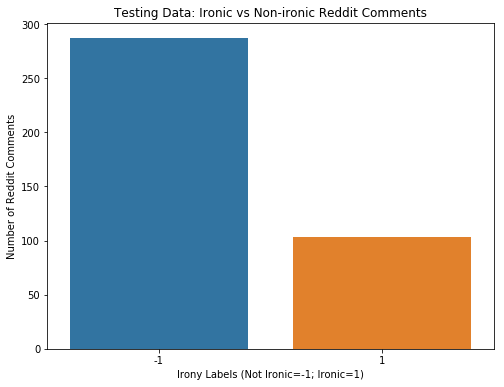

In [24]:
#TEST

fig = plt.figure(figsize=(8,6))
sns.barplot(x = test["Label"].unique(), 
            y=test["Label"].value_counts())

plt.title("Testing Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

# TRAIN

In [20]:
#check format of train df
train.head()

,Label,Comment_Text
254,-1,Matthews must mistakenly think that if O'Reill...
331,1,Yep it is hard to get a good education and the...
1141,-1,/r/nottheonion
1642,-1,About. Fucking. Time.
1064,-1,The perimeters around this relaunching were ke...


In [27]:
#Split Train set into "Ironic" and "Non-ironic" DataFrames
ironic_train = train[train["Label"] == 1]
nonironic_train = train[train["Label"] == -1]

In [28]:
#Convert into two dictionaries
ironic_dict = ironic_train.set_index(ironic_train.index).T.to_dict()
nonironic_dict = nonironic_train.set_index(nonironic_train.index).T.to_dict()

print(f"Training data contains {len(ironic_dict)} IRONIC comments")
print(f"Training data contains {len(nonironic_dict)} NON- IRONIC comments")

Training data contains 387 IRONIC comments
Training data contains 977 NON- IRONIC comments


# (2)
# FUNCTION LIST

In [91]:
def get_all_tokens(test_dict):
    """Input dictionary and return list of comments as SpaCy docs"""
    comment_list = []
    for comment_index, label in test_dict.items():
        for key in label:
            text = label[key]
            if type(text) == str:
                comment_list.append(nlp(text))
    return comment_list

In [31]:
def get_words(listx):
    """Take a list (already parsed through SpaCy) remove punctuation and return list of word tokens"""
    ir_clean_docs = [] #remove punctuation

    for x in listx:
        clean_list = []
        for y in x:
            if y.pos_ != 'PUNCT':
                clean_list.append(y)
        ir_clean_docs.append(clean_list)
    return ir_clean_docs

In [32]:
def get_punct(listx):
    """Take a list (already parsed through spacy), remove words and return list of punctuation ONLY"""
    ir_punct = [] #only punctuation

    for x in listx:
        clean_list = []
        for y in x:
            if y.pos_ == 'PUNCT':
                clean_list.append(y)
        ir_punct.append(clean_list)
    return ir_punct

In [33]:
def average_word_length(doc):
    """Take doc and return average word length"""
    for token in doc:
        word = token.text
        average_word_length = sum(len(word) for word in doc) / len(doc)
    return(average_word_length)

In [34]:
def average_sent_length(doc):
    """Take doc and return average sentence length"""
    sent_list = []

    for sent in doc.sents:
        len_sent = len(sent)
        sent_list.append(len_sent)

    total = sum(sent_list)
    leng = len(sent_list)

    average_sent_length = total / leng
    return(average_sent_length)

In [36]:
def check_sarcsymbol(doc):
    """Take a list of comments (parsed through SpaCy); return list with average number of "/s" symbols per comment [Reddit "/s" = sarcasm]"""
    sarcsymb = []
    leng = len(doc) 
    h = 1
    
    for x in doc: 
        if x.text == "/s" or x.text == "/sarcasm" or x.text == "/sarc":
            sarcsymb.append(h/leng) 
        else:
            pass
               
    return sarcsymb

In [78]:
def count_uppercase(doc):
    """Take nlp doc and return the average number of fully uppercase words for each comment as a list"""
    new_list = []
    
    leng = len(doc)
    for token in doc:
        if token.is_upper == True:
            new_list.append(token)
            
    counting = Counter(new_list)
    my_dict = dict(counting)
    
    upper_count_avg = []

    x = sum(my_dict.values())
    upper_count_avg.append(x/leng)
    
    return upper_count_avg

In [37]:
def get_punct_average(punctuation_list, token_comment_list):
    """Take preprocessed list of punctuation and full token list (MUST be of equal length); 
    Returns list of the average for ALL punctuation (based on number overall of tokens)
    for each comment""" 

    punct_count = []
    for comment in punctuation_list:
        punct_count.append(len(comment))

    len_comment = []
    for comment in token_comment_list:
        len_comment.append(len(comment))
    
    punct_count, len_comment = np.array(punct_count), np.array(len_comment) 
    averages = punct_count + len_comment/2
    return averages

In [38]:
def get_indiv_punct(doc):
    """Return relative count average for all word types i.e. nouns, pronouns, verbs etc with word type as key and average as value"""
    punc_tags = []
    for token in doc:
        if token.is_punct:
            punc_tags.append(token)
            
    
    #make each a string so not multiple keys with same vaues
    punc_tags = [str(punc) for punc in punc_tags]
           

    punc_tag_dict = Counter(punc_tags) #returns dictionary with whole count for each word type in doc
    
    leng = len(doc) #overall length of doc (no. of tokens)
    new_dict = {}
    
    for key, value in punc_tag_dict.items(): #iterate over entire dict
        new_dict[key] = value/ leng
            
    final_dict = dict(new_dict)
            
    return final_dict

In [191]:
def relative_count_wordtypes(doc):
    """Return relative count average for all word types i.e. nouns, pronouns, verbs etc with word type as key and average as value"""
    pos_tags = []
    for token in doc:
        pos_tags.append(token.pos_)
    counting = Counter(pos_tags) #returns dictionary with whole count for each word type in doc
    
    leng = len(doc) #overall length of doc (no. of tokens)
    new_dict = {}
    
    for key, value in counting.items(): #iterate over entire dict
        new_dict[key] = value/ leng
            
            
    return new_dict

In [192]:
def get_entities(doc):
    """Take nlp doc and return a dictionary with key as ent.labe_ and value as the average number"""
    entity = []
    for token in doc.ents:
        entity.append(token.label_)

    new_dict = Counter(entity)
    leng = len(doc)
    
    for key, value in new_dict.items():
        new_dict[key] = value / leng
        
    ent_dict = dict(new_dict)
    
    return ent_dict



# (3)
# IRONY TRAINING

In [49]:
#1) GET ALL TOKENS
ir_tokens = get_all_tokens(ironic_dict)

In [51]:
#2) Get list of ONLY words (no punct)
ir_word_list = get_words(ir_tokens)

In [52]:
#3) Get list of ONLY punct (no words)
ir_punct_list = get_punct(ir_tokens)

In [53]:
#Create df for total, full returns for irony
total_ir_train= pd.DataFrame({'Ironic Comment Parsed':ir_tokens})
total_ir_train["Tokens"] = ir_word_list
total_ir_train["Punctuation"] = ir_punct_list
total_ir_train.head()

,Ironic Comment Parsed,Tokens,Punctuation
0,"(Yep, it, is, hard, to, get, a, good, educatio...","[Yep, it, is, hard, to, get, a, good, educatio...",[.]
1,"(So, the, question, during, their, Twitter, Q&...","[So, the, question, during, their, Twitter, Q&...","[..., .]"
2,"(They, hate, us, for, our, freedom, .)","[They, hate, us, for, our, freedom]",[.]
3,"(Did, he, talk, at, all, about, how, he, place...","[Did, he, talk, at, all, about, how, he, place...",[?]
4,"(&, gt, ;, "", Here, 's, a, picture, of, my, ho...","[&, gt, Here, 's, a, picture, of, my, house, \...","[;, "", "", ?, ?, ?]"


In [60]:
#4) AVERAGE WORD LENGTH
ir_average_word_leng = []
for comment in ir_word_list:
    ir_average_word_leng.append(average_word_length(comment))
    
#Create DataFrame for Summary of Irony STATS
summary_irony= pd.DataFrame({"Average Word Length": ir_average_word_leng})

In [61]:
#5) AVERAGE SENTENCE LENGTH
ir_average_sent_leng = []
for x in ir_tokens:
    ir_average_sent_leng.append(average_sent_length(x))

#Add to Summary of Irony STATS df
summary_irony["Average Sentence Length"] = ir_average_sent_leng
summary.head()

,Average Word Length,Average Sentence Length
0,3.826087,24.0
1,4.636364,17.5
2,3.833333,7.0
3,4.444444,19.0
4,2.619048,9.0


In [63]:
#6) AVERAGE NUMBER OF SARCASM SYMBOL (/s)

ir_sarcfunc = []
for x in ir_tokens:
    ir_sarcfunc.append(check_sarcsymbol(x))


ir_sarcsymb_list = []        
for l in ir_sarcfunc:
    if len(l) >= 1:
        ir_sarcsymb_list.append(l)
    else:
        ir_sarcsymb_list.append([0])

#Remove list layer 
ir_sarcsymb_list = list(chain.from_iterable(ir_sarcsymb_list))

#Add result to Ironic Summary DF
summary_irony["Sarcasm Symbol (/s)"] = ir_sarcsymb_list

In [123]:
#7) AVERAGE NUMBER OF UPPER CASE WORDS (total)

ir_uppercase_list = []
for b in ir_tokens:
    ir_uppercase_list.append((count_uppercase(b)))
    
#Remove list layer 
ir_uppercase_list = list(chain.from_iterable(ir_uppercase_list))

#Add result to Ironic Summary DF
summary_irony["Uppercase Average"] = ir_uppercase_list
summary_irony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Punctuation Richness,Uppercase Average
0,3.826087,24.0,0.0,13.0,0.0
1,4.636364,17.5,0.0,19.5,0.0
2,3.833333,7.0,0.0,4.5,0.0
3,4.444444,19.0,0.0,10.5,0.0
4,2.619048,9.0,0.0,19.5,0.0


In [79]:
#8) AVERAGE PUNCTUATION RICHNESS
ir_punct_avg = get_punct_average(ir_punct_list, ir_tokens)

#Add result to Ironic Summary DF
summary_irony["Punctuation Richness"] = ir_punct_avg
summary_irony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Punctuation Richness,Uppercase Average
0,3.826087,24.0,0.0,13.0,[0]
1,4.636364,17.5,0.0,19.5,[0]
2,3.833333,7.0,0.0,4.5,[0]
3,4.444444,19.0,0.0,10.5,[0]
4,2.619048,9.0,0.0,19.5,[0]


In [89]:
#9) AVERAGE FOR ALL PUNCTUATION MARKS (each individual)

ir_average_indivpunc_list = []
for x in ir_tokens:
    ir_average_indivpunc_list.append(get_indiv_punct(x))

#Create Summary DF for each individual Punctuation Mark
summary_irony_indivpunct = pd.DataFrame(ir_average_indivpunc_list)
summary_irony_indivpunct.head()

,!,"""",""")",%,&,',(,),*,",",...,?,[,\,],_,–,—,‘,“,”
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.052632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.074074,NaN,NaN,0.037037,NaN,NaN,NaN,NaN,NaN,...,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
#10) AVERAGE FOR ALL WORD TYPES 

ir_average_wordtype_list = []
for comment in ir_tokens:
    ir_average_wordtype_list.append(relative_count_wordtypes(comment))

#Create Summary DF for Word Types
summary_irony_wordtype = pd.DataFrame(ir_average_wordtype_list)
summary_irony_wordtype.head()

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
0,0.125000,0.041667,0.083333,0.041667,0.125000,0.041667,0.166667,NaN,0.041667,0.083333,NaN,0.041667,NaN,NaN,0.208333,NaN
1,0.085714,0.171429,0.028571,0.028571,0.085714,NaN,0.285714,NaN,0.028571,0.028571,0.028571,0.057143,NaN,NaN,0.171429,NaN
2,0.142857,0.142857,NaN,NaN,NaN,NaN,0.142857,NaN,NaN,0.285714,NaN,0.142857,NaN,NaN,0.142857,NaN
3,0.157895,0.157895,0.157895,NaN,0.052632,NaN,0.157895,NaN,NaN,0.105263,NaN,0.052632,NaN,NaN,0.157895,NaN
4,0.037037,0.037037,0.148148,0.037037,0.074074,0.037037,0.148148,NaN,NaN,0.037037,NaN,0.222222,0.111111,NaN,0.111111,NaN


In [87]:
#11) AVERAGE FOR ALL NAMED ENTITIES 
ir_named_entity_list = []
for comment in ir_tokens:
    ir_named_entity_list.append(get_entities(comment))
    

#Create Summary DF for all Named Entities   
summary_irony_namedentity = pd.DataFrame(ir_named_entity_list)
summary_irony_namedentity.head()  

,CARDINAL,DATE,EVENT,FAC,GPE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# (4)
# NO-IRONY 

In [92]:
#1) GET ALL TOKENS
nonir_tokens = get_all_tokens(nonironic_dict)

In [94]:
#2) Get list of ONLY words (no punct)
nonir_word_list = get_words(nonir_tokens)

In [95]:
#3) Get list of ONLY punct (no words)
nonir_punct_list = get_punct(nonir_tokens)

In [96]:
#Create df for total, full returns for irony
total_nonir_train= pd.DataFrame({'non-ironic Comment Parsed':nonir_tokens})
total_nonir_train["Tokens"] = nonir_word_list
total_nonir_train["Punctuation"] = nonir_punct_list
total_nonir_train.head()

,non-ironic Comment Parsed,Tokens,Punctuation
0,"(Matthews, must, mistakenly, think, that, if, ...","[Matthews, must, mistakenly, think, that, if, ...",[.]
1,"(/r, /, nottheonion)","[/, nottheonion]",[/r]
2,"(About, ., , Fucking, ., , Time, .)","[About, , Fucking, , Time]","[., ., .]"
3,"(The, perimeters, around, this, relaunching, w...","[The, perimeters, around, this, relaunching, w...",[.]
4,"(Typical, liberal)","[Typical, liberal]",[]


In [97]:
#4) AVERAGE WORD LENGTH
nonir_average_word_leng = []
for comment in nonir_word_list:
    nonir_average_word_leng.append(average_word_length(comment))
    
#Create DataFrame for Summary of Irony STATS
summary_noirony= pd.DataFrame({"Average Word Length": nonir_average_word_leng})

In [98]:
#5) AVERAGE SENTENCE LENGTH
nonir_average_sent_leng = []
for x in nonir_tokens:
    nonir_average_sent_leng.append(average_sent_length(x))

#Add to Summary of Irony STATS df
summary_noirony["Average Sentence Length"] = nonir_average_sent_leng
summary_noirony.head()

,Average Word Length,Average Sentence Length
0,4.750000,17.000000
1,6.000000,3.000000
2,3.600000,2.666667
3,5.285714,22.000000
4,7.000000,2.000000


In [99]:
#6) AVERAGE NUMBER OF SARCASM SYMBOL (/s)

nonir_sarcfunc = []
for x in nonir_tokens:
    nonir_sarcfunc.append(check_sarcsymbol(x))


nonir_sarcsymb_list = []        
for l in nonir_sarcfunc:
    if len(l) >= 1:
        nonir_sarcsymb_list.append(l)
    else:
        nonir_sarcsymb_list.append([0])

#Remove list layer 
nonir_sarcsymb_list = list(chain.from_iterable(nonir_sarcsymb_list))

#Add result to Ironic Summary DF
summary_noirony["Sarcasm Symbol (/s)"] = nonir_sarcsymb_list

In [127]:
#7) AVERAGE NUMBER OF UPPER CASE WORDS (total)

nonir_uppercase_list = []
for b in nonir_tokens:
    nonir_uppercase_list.append((count_uppercase(b)))
    
    
#Remove list layer 
nonir_uppercase_list = list(chain.from_iterable(nonir_uppercase_list))

#Add result to Ironic Summary DF
summary_noirony["Uppercase Average"] = nonir_uppercase_list
summary_noirony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average,Punctuation Richness
0,4.750000,17.000000,0,0.0,9.5
1,6.000000,3.000000,0,0.0,2.5
2,3.600000,2.666667,0,0.0,7.0
3,5.285714,22.000000,0,0.0,12.0
4,7.000000,2.000000,0,0.0,1.0


In [103]:
#8) AVERAGE PUNCTUATION RICHNESS
nonir_punct_avg = get_punct_average(nonir_punct_list, nonir_tokens)

#Add result to Ironic Summary DF
summary_noirony["Punctuation Richness"] = nonir_punct_avg
summary_noirony.head()

,Average Word Length,Average Sentence Length,Sarcasm Symbol (/s),Uppercase Average,Punctuation Richness
0,4.750000,17.000000,0,[0.0],9.5
1,6.000000,3.000000,0,[0.0],2.5
2,3.600000,2.666667,0,[0.0],7.0
3,5.285714,22.000000,0,[0.0],12.0
4,7.000000,2.000000,0,[0.0],1.0


In [105]:
#9) AVERAGE FOR ALL PUNCTUATION MARKS (each individual)

nonir_average_indivpunc_list = []
for x in nonir_tokens:
    nonir_average_indivpunc_list.append(get_indiv_punct(x))

#Create Summary DF for each individual Punctuation Mark
summary_noirony_indivpunct = pd.DataFrame(nonir_average_indivpunc_list)
summary_noirony_indivpunct.head()

,!,"""",#,%,&,',(,),*,",",...,?,[,],_,§,–,—,‘,“,”
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
#10) AVERAGE FOR ALL WORD TYPES 

nonir_average_wordtype_list = []
for comment in nonir_tokens:
    nonir_average_wordtype_list.append(relative_count_wordtypes(comment))

#Create Summary DF for Word Types
summary_noirony_wordtype = pd.DataFrame(nonir_average_wordtype_list)
summary_noirony_wordtype.head()

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
0,NaN,0.176471,0.058824,NaN,0.117647,NaN,0.117647,NaN,NaN,0.058824,0.117647,0.058824,NaN,NaN,0.294118,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,0.333333,NaN,0.333333,NaN,NaN
2,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.375000,0.25,NaN,NaN,NaN
3,0.090909,0.090909,0.045455,NaN,0.227273,NaN,0.181818,NaN,0.045455,NaN,NaN,0.045455,NaN,NaN,0.272727,NaN
4,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
#11) AVERAGE FOR ALL NAMED ENTITIES 
nonir_named_entity_list = []
for comment in nonir_tokens:
    nonir_named_entity_list.append(get_entities(comment))
    

#Create Summary DF for all Named Entities   
summary_noirony_namedentity = pd.DataFrame(nonir_named_entity_list)
summary_noirony_namedentity.head()  

,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058824,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# (5)
# GET FINAL STATS FOR TRAINING 

- (1) General Summary: create shared DF (1, -1) with mean, save to CSV and show visual
- (2) Word Type summary: create shared DF (1, -1) with mean, save to CSV and show visual
- (3) Punctuation Mark summary: create shared DF (1, -1) with mean, save to CSV and show visual
- (4) Named Entity Recognition summary: create shared DF (1, -1) with mean, save to CSV and show visual

# (5.1) General Summary

In [112]:
#1) WORD LENGTH summary
ir_dist_word = summary_irony["Average Word Length"].mean()
non_ir_dist_word = summary_noirony["Average Word Length"].mean()

In [113]:
#2) SENTENCE LENGTH summary
ir_dist_sent = summary_irony["Average Sentence Length"].mean() 
non_ir_dist_sent = summary_noirony["Average Sentence Length"].mean()

In [118]:
#3) SARCASM SYMBOL (/s) summary
ir_sarcsymb = summary_irony["Sarcasm Symbol (/s)"].mean()
non_ir_sarcsymb = summary_noirony["Sarcasm Symbol (/s)"].mean()

In [114]:
#4) PUNCTUATION RICHNESS summary
ir_dist_punct = summary_irony["Punctuation Richness"].mean()
non_ir_dist_punct = summary_noirony["Punctuation Richness"].mean()

In [128]:
#5) UPPER-CASE LETTER summary
ir_uppercase = summary_irony["Uppercase Average"].mean()
non_ir_uppercase = summary_noirony["Uppercase Average"].mean()

In [130]:
#Create a Summary Stats df
# View both ironic/non-ironic average stats for each feature

summary_stats = pd.DataFrame(columns=["Average Word Length","Average Sentence Length"], index=["Ironic Comments", "Non-ironic Comments"])

summary_stats["Average Word Length"] = ir_dist_word, non_ir_dist_word
summary_stats["Average Sentence Length"] = ir_dist_sent, non_ir_dist_sent
summary_stats["Average '/s' symbol count"] = ir_sarcsymb, non_ir_sarcsymb
summary_stats["Average Upper-case Words"] = ir_uppercase, non_ir_uppercase
summary_stats["Punctuation Richness"] = ir_dist_punct, non_ir_dist_punct

summary_stats

,Average Word Length,Average Sentence Length,Average '/s' symbol count,Average Upper-case Words,Punctuation Richness
Ironic Comments,4.304183,14.261968,0.000783,0.02535,20.927649
Non-ironic Comments,4.411010,15.805244,0.000000,0.02346,36.150972


In [131]:
#Save Master general table to CSV

new_filename= "/Users/laure/OneDrive/Dokumente/VU/Python for Text Analysis/Final Assignment/train_summary_general.csv"

summary_stats.to_csv(new_filename)

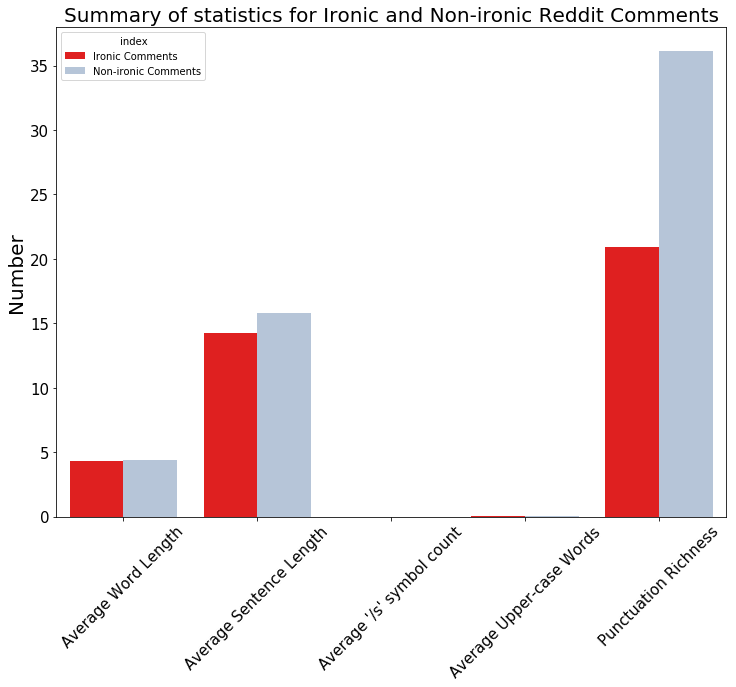

In [134]:
#Create Visualisation for Summary-stats DataFrame

reset_indexbar = summary_stats.reset_index().melt(id_vars=["index"]) 

plt.figure(figsize=(12,9)) #size on-screen
sns.barplot(x="variable", y="value", hue="index", data=reset_indexbar, palette=["red", "lightsteelblue"] )
plt.xticks(rotation=45)


plt.title("Summary of statistics for Ironic and Non-ironic Reddit Comments", fontsize=20)
plt.ylabel("Number", fontsize=20)
plt.xlabel("")
plt.tick_params(labelsize=15)

# (5.2) Word-Type Summary

In [157]:
#IRONIC word-type

ir_wordtype = summary_irony_wordtype.mean()
ir_wordtype = pd.DataFrame(ir_wordtype) 

#Clean df (switch columns, rename index, move index inwards to right (for grouped bar later))
ir_wordtype = ir_wordtype.T #transpose columns w. rows

In [158]:
#NON-IRONIC word-type

nonir_wordtype = summary_noirony_wordtype.mean()
non_ir_wordtype = pd.DataFrame(nonir_wordtype) 

#clean df (switch columns, rename index, move index inwards to right (for grouped bar later))
non_ir_wordtype = non_ir_wordtype.T #transpose columns w. rows

In [159]:
#WORD TYPE SUMMARY!
word_type_frames = [ir_wordtype, non_ir_wordtype]
summary_word_type = pd.concat(word_type_frames)
summary_word_type.index = "Ironic", "Non-ironic"

summary_word_type

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
Ironic,0.107941,0.100968,0.094626,0.044592,0.092337,0.051884,0.177171,0.053856,0.048675,0.091132,0.102975,0.148505,0.061451,0.047691,0.184374,0.022459
Non-ironic,0.096721,0.098474,0.087175,0.041438,0.094548,0.047330,0.171229,0.039677,0.041457,0.078976,0.075606,0.145210,0.047385,0.046536,0.191246,0.024723


In [156]:
#Save Master general table to CSV

new_filename= "/Users/laure/OneDrive/Dokumente/VU/Python for Text Analysis/Final Assignment/train_summary_wordtype.csv"

summary_word_type.to_csv(new_filename)

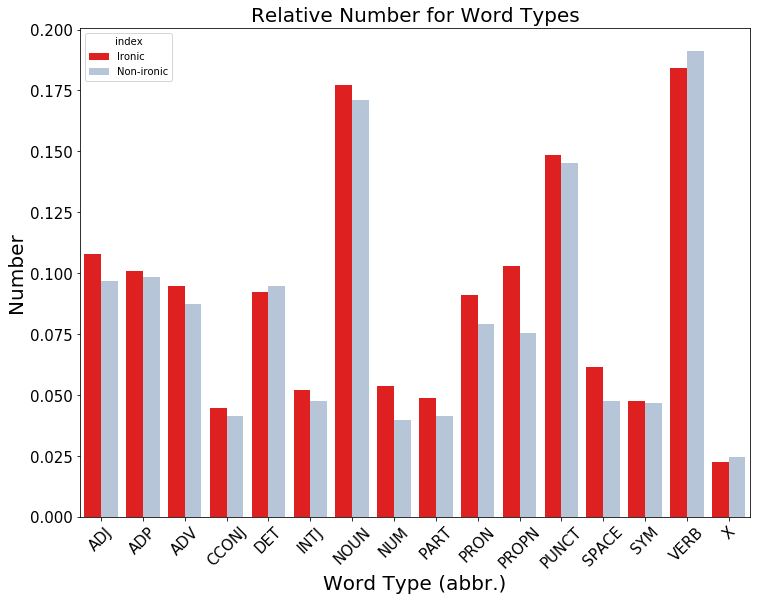

In [160]:
#WORD TYPE VISUAL SUMMARY

reset_indexbar_wordtypes = summary_word_type.reset_index().melt(id_vars=["index"]) 
#summary_stats.head()

plt.figure(figsize=(12,9)) #size on-screen
sns.barplot(x="variable", y="value", hue="index", data=reset_indexbar_wordtypes, palette=["red", "lightsteelblue"] )
plt.xticks(rotation=45)

# #instead of palette, try -- color = "lightsteelblue"

plt.title("Relative Number for Word Types", fontsize=20)
plt.ylabel("Number", fontsize=20)
plt.xlabel("Word Type (abbr.)", fontsize=20)

#plt.xlabel("Statistics Type", fontsize=15)
plt.tick_params(labelsize=15)


# (5.3) Punctuation Mark

In [175]:
#INDIVIDUAL PUNCT COUNT AVERAGE

#IRONIC
ir_punct_mean = summary_irony_indivpunct.mean()
ir_punct = pd.DataFrame(ir_punct_mean)
summary_ir_punct = ir_punct.T
summary_ir_punct.index.names = ["Ironic"]

In [176]:
#NON-IRONIC
nonir_punct_mean = summary_noirony_indivpunct.mean()
nonir_punct = pd.DataFrame(nonir_punct_mean)
summary_nonir_punct = nonir_punct.T
summary_nonir_punct.index.names = ["Non-ironic"]

In [177]:
indiv_punct_frames = [summary_ir_punct, summary_nonir_punct]
summary_punct_count = pd.concat(indiv_punct_frames, sort=True)
summary_punct_count.index = "Ironic", "Non-ironic"

In [180]:
#replace NaN with 0 for easier understanding
summary_punct_count = summary_punct_count.replace(np.nan, 0)
summary_punct_count

,!,"""",""")",#,%,&,',(,),*,...,[,\,],_,§,–,—,‘,“,”
Ironic,0.093206,0.063918,0.003165,0.000000,0.047312,0.020822,0.070586,0.017297,0.018151,0.092469,...,0.023683,0.032258,0.032581,0.018987,0.000000,0.003165,0.029412,0.003165,0.018484,0.020308
Non-ironic,0.084272,0.050790,0.000000,0.027027,0.022251,0.020579,0.053885,0.018097,0.021424,0.055709,...,0.076399,0.000000,0.122762,0.011111,0.011765,0.011765,0.009143,0.008478,0.011914,0.012630


In [181]:
#Save Master general table to CSV

indivpunct_filename= "/Users/laure/OneDrive/Dokumente/VU/Python for Text Analysis/Final Assignment/train_summary_puncttype.csv"

summary_punct_count.to_csv(indivpunct_filename)

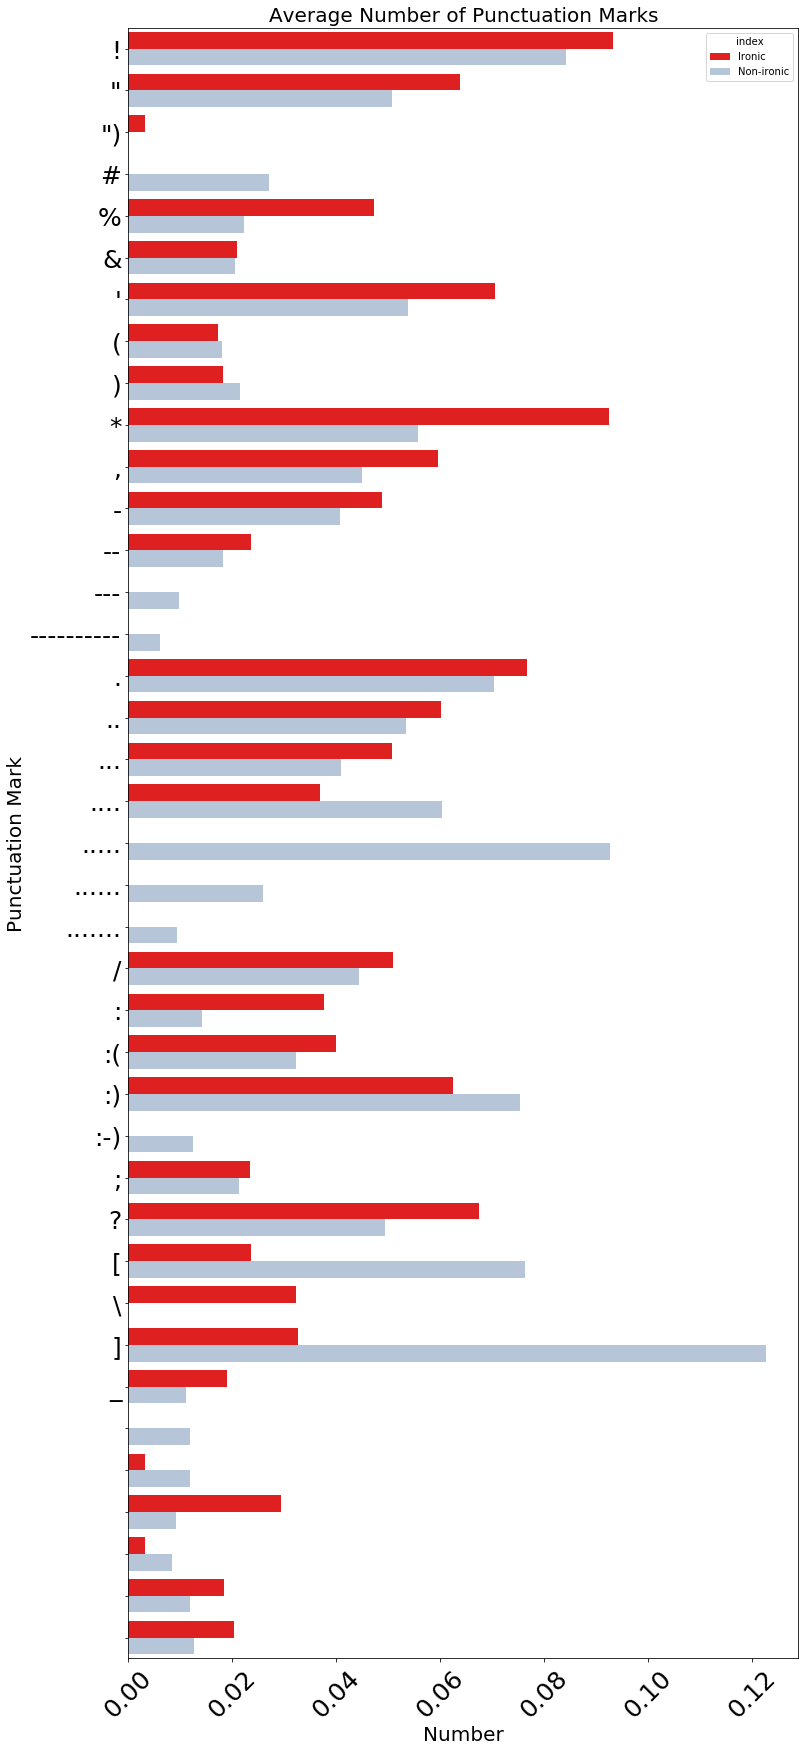

In [187]:
#INDIVIDUAL PUCNTUATION VISUAL SUMMARY

reset_indexbar_indpunct = summary_punct_count.reset_index().melt(id_vars=["index"]) 
#summary_punct_count.head()

plt.figure(figsize=(12,30)) #size on-screen
sns.barplot(x="value", y="variable", hue="index", data=reset_indexbar_indpunct, palette=["red", "lightsteelblue"] )
plt.xticks(rotation=45)

# #instead of palette, try -- color = "lightsteelblue"

plt.title("Average Number of Punctuation Marks", fontsize=20)
plt.ylabel("Punctuation Mark", fontsize=20)
plt.xlabel("Number", fontsize=20)

#plt.xlabel("Statistics Type", fontsize=15)
plt.tick_params(labelsize=25)

# (5.4) NAMED-ENTITIES

In [184]:
#IRONIC

ir_entity = summary_irony_namedentity.mean()
ir_entity = pd.DataFrame(ir_entity) 

#clean df (switch columns, rename index, move index inwards to right (for grouped bar later))
ir_entity = ir_entity.T #transpose columns w. rows

In [185]:
#NON-IRONIC

non_ir_entity = summary_noirony_namedentity.mean()
non_ir_entity = pd.DataFrame(non_ir_entity)

# #clean df (switch columns, rename index, move index inwards to right (for grouped bar later))
non_ir_entity = non_ir_entity.T #transpose columns w. rows

In [186]:
#NAMED ENTITIES grouped summary df

entity_frames = [ir_entity, non_ir_entity]
summary_entity = pd.concat(entity_frames, sort=True)
summary_entity.index = "Ironic", "Non-ironic"
summary_entity

,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
Ironic,0.041123,0.045283,0.025641,0.003165,0.048072,NaN,0.015036,0.039665,0.036168,0.044726,0.033967,0.055027,0.045914,0.047837,0.011140,0.003165,0.03235,0.027053
Non-ironic,0.034334,0.023964,0.009453,0.012705,0.029929,0.021429,0.020590,0.019512,0.025125,0.034095,0.017485,0.032427,0.025188,0.037660,0.009576,0.021969,0.01667,0.018885


In [188]:
#Save Master general table to CSV

namedentity_filename= "/Users/laure/OneDrive/Dokumente/VU/Python for Text Analysis/Final Assignment/train_summary_namedentity.csv"

summary_entity.to_csv(namedentity_filename)

In [189]:
#NER VISUAL SUMMARY

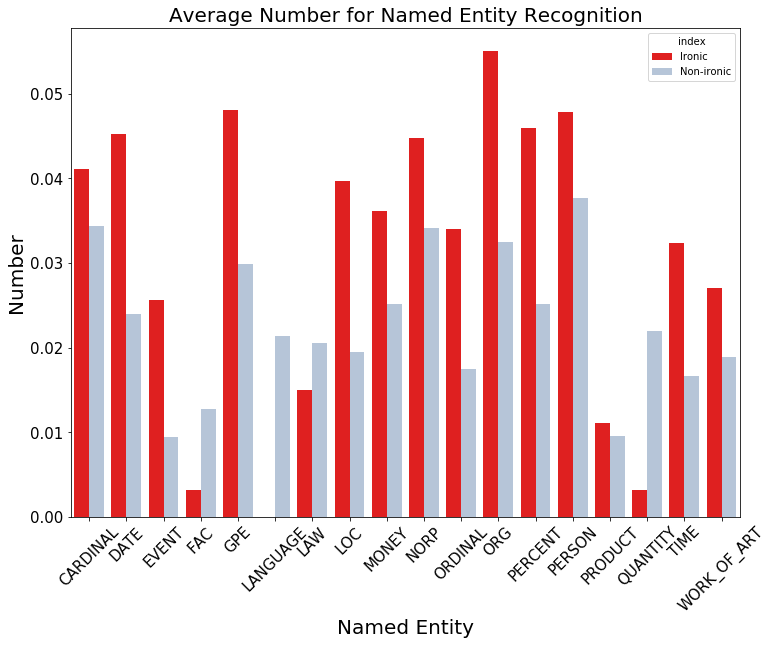

In [190]:
#NAMED ENTITY SUMMARY VISUAL 

reset_indexbar_entity = summary_entity.reset_index().melt(id_vars=["index"]) 

plt.figure(figsize=(12,9)) #size on-screen
sns.barplot(x="variable", y="value", hue="index", data=reset_indexbar_entity, palette=["red", "lightsteelblue"] )
plt.xticks(rotation=45)

plt.title("Average Number for Named Entity Recognition", fontsize=20)
plt.ylabel("Number", fontsize=20)
plt.xlabel("Named Entity", fontsize=20)

plt.tick_params(labelsize=15)